In [2]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
# sys.path.append("./")
# sys.path.append("../")
sys.path.append("../../")

from src.config import  PACKAGE_PATH, FourierDatasetConfig, FCConfig
from src.experiments.utils import run_experiment
from src.experiments.constants import *
from src.experiments.utils import get_default_cfg, load_dataset_to_trainer
from src.train import Trainer
from src.nn.networks.utils import get_new_net, load_net, save_net
from src.nn.datasets.fourier import FourierDataset
from src.nn.networks.fc import FC

In [4]:
cfg = get_default_cfg()

cfg.data_config.dataset_class = "FourierDataset"
cfg.data_config.dataset_arguments = FourierDatasetConfig(
    amplitude=True, fourier=True,push_to_max=True,
    rms=False, residuals=False, lc=False, reconstructed_lc=False).__dict__

dataset_name = cfg.data_config.dataset_class + "_".join([f"{k}_{v}" for k,v in cfg.data_config.dataset_arguments.items()])
dataset_name += f"_{MAX_EXAMPLES}"
dataset_path = "/media/bach/DATA/work/classification_of_light_curves/output/datasets/Experiments/"
dataset_path += dataset_name
data = np.load(f"{dataset_path}/train_x.npy")
labels = np.load(f"{dataset_path}/train_y.npy")

In [54]:
cfg.net_config.net_class = "FC"
cfg.net_config.model_config = FCConfig(
    input_size=16,
    output_size=5,
    layers=[256,256,256]
)
cfg.net_config.save_path = f"{PACKAGE_PATH}/output/models/Fourier_trained"

CKPT = 0
EPOCH = 200
IDX = "19"
model_path = f"/media/bach/DATA/work/classification_of_light_curves/output/models/FC_central_loss_{IDX}/"
model_path += f"/FC_epochs_{EPOCHS}_checkpoint_{CKPT:03d}.model" 
net = FC(cfg.net_config.model_config)
net.load_state_dict(torch.load(model_path))
net.eval()

transformed_data, _ = net.forward(torch.Tensor(data), features=True)
transformed_data = transformed_data.detach().cpu().numpy()

In [55]:
data.shape, labels.shape, transformed_data.shape

((19765, 16), (19765,), (19765, 256))

In [71]:
N = 19765
use_data = data[:N]
# N = 10_000
reduced_data = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(use_data)
reduced_labels = labels[:N]

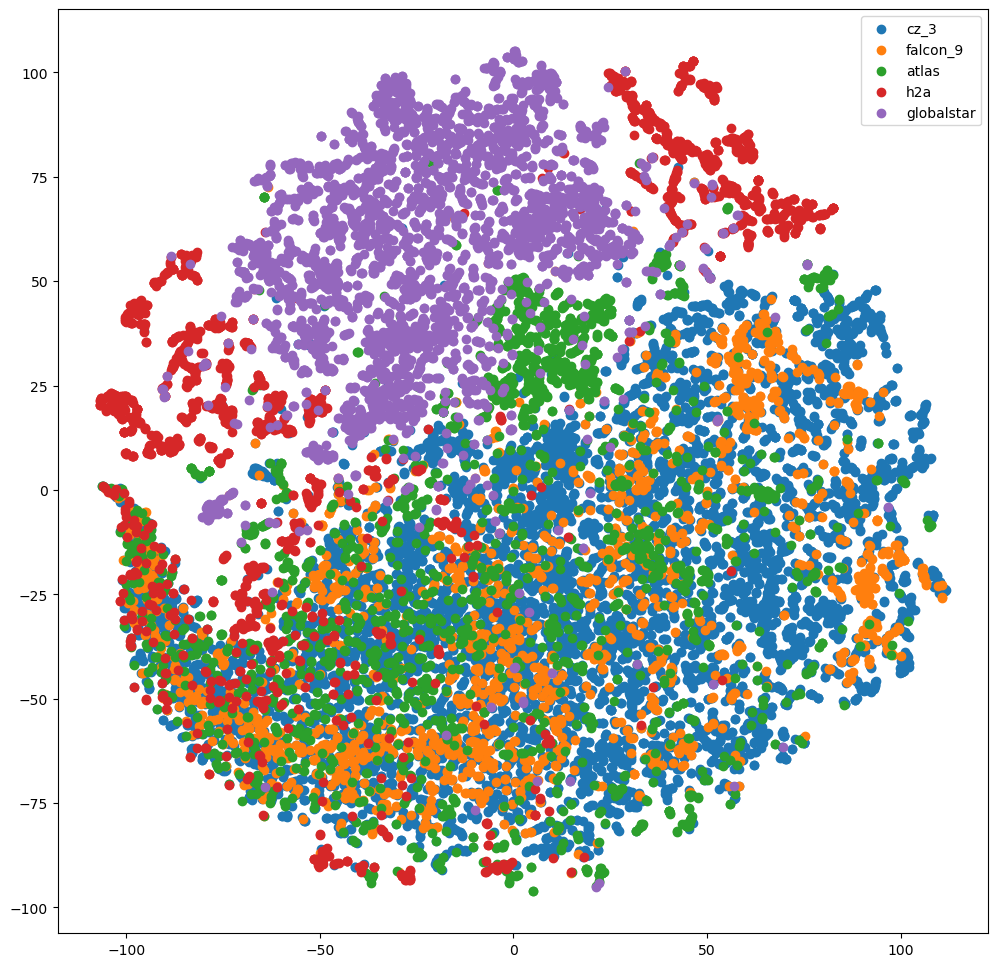

In [72]:
fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(projection='3d')
ax = fig.add_subplot()

for l in np.unique(reduced_labels):
    ok = reduced_labels == l
    # create 3D scatter plot
    plt.scatter(reduced_data[ok, 0], reduced_data[ok, 1], label=cfg.data_config.labels[l])
    # ax.scatter(reduced_data[ok, 0], reduced_data[ok, 1], reduced_data[ok, 2], label=cfg.data_config.labels[l])
plt.legend()
fig.savefig(f"TSNE_FC_A_RMS.png")
# plt.show()

IndexError: index 2 is out of bounds for axis 1 with size 2

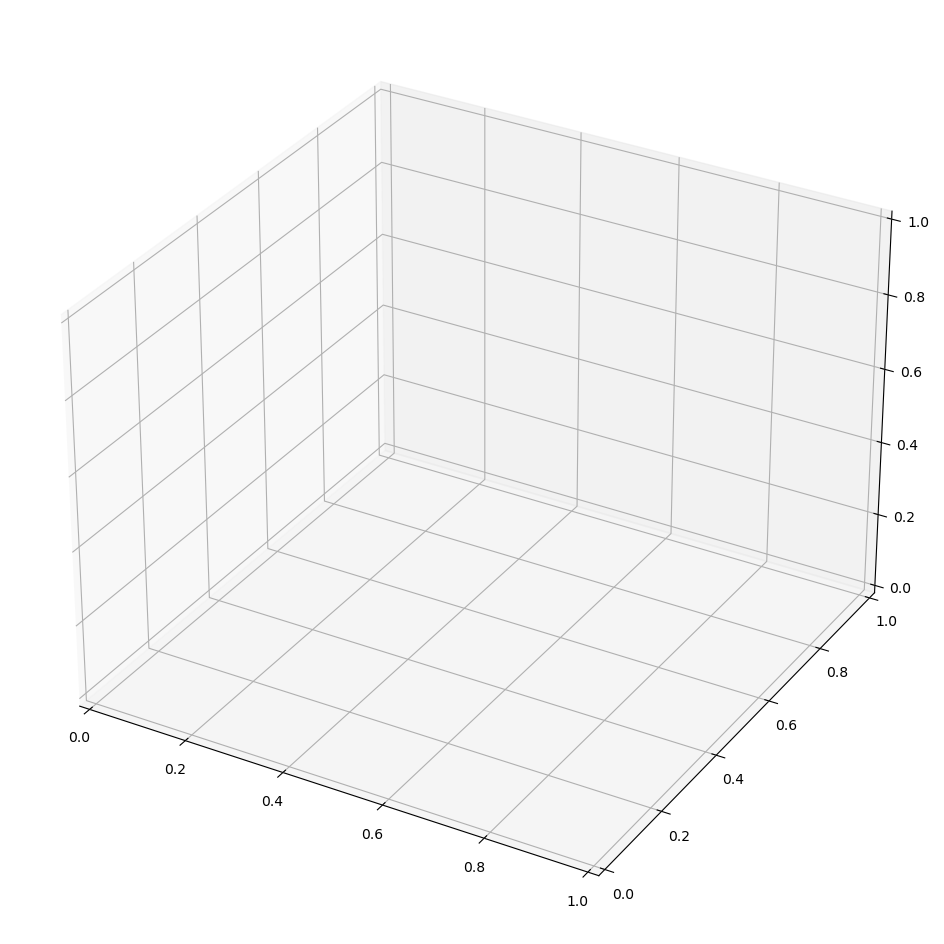

In [19]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

for l in np.unique(reduced_labels):
    ok = reduced_labels == l
    # create 3D scatter plot
    # plt.scatter(reduced_data[ok, 0], reduced_data[ok, 1], label=cfg.data_config.labels[l])
    ax.scatter(reduced_data[ok, 0], reduced_data[ok, 1], reduced_data[ok, 2], label=cfg.data_config.labels[l])
plt.legend()
plt.show()

In [80]:
import pandas as pd
df = pd.DataFrame(data[labels==4])
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/tmp/ipykernel_41511/3675251813.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.00,0.02,0.29,-0.06,-0.13,-0.06,0.04,-0.03,0.03,0.02,0.04,0.05,0.01,0.04,0.01,-0.01,-0.31
1,0.02,1.00,-0.01,0.41,0.03,0.15,0.09,0.40,0.03,0.01,0.03,0.06,0.05,0.06,0.01,0.01,-0.62
2,0.29,-0.01,1.00,0.10,0.06,0.04,0.24,0.02,0.02,0.06,0.01,0.03,-0.03,-0.03,-0.05,0.01,-0.27
3,-0.06,0.41,0.10,1.00,0.02,0.16,0.11,0.71,0.04,0.01,0.04,0.03,-0.05,0.05,-0.02,-0.02,-0.65
4,-0.13,0.03,0.06,0.02,1.00,0.18,0.15,0.02,0.01,-0.01,-0.07,0.02,-0.08,-0.08,-0.00,-0.02,-0.12
5,-0.06,0.15,0.04,0.16,0.18,1.00,0.16,0.21,0.02,0.01,-0.07,-0.02,0.01,-0.02,-0.02,-0.00,-0.29
6,0.04,0.09,0.24,0.11,0.15,0.16,1.00,0.09,-0.04,-0.10,-0.06,-0.05,-0.09,0.03,0.01,0.02,-0.17
7,-0.03,0.40,0.02,0.71,0.02,0.21,0.09,1.00,0.04,-0.03,0.03,-0.02,-0.01,0.07,0.01,-0.02,-0.57
8,0.03,0.03,0.02,0.04,0.01,0.02,-0.04,0.04,1.00,0.02,-0.14,-0.02,-0.04,0.01,-0.04,-0.00,-0.12
9,0.02,0.01,0.06,0.01,-0.01,0.01,-0.10,-0.03,0.02,1.00,0.03,-0.06,-0.09,-0.06,-0.05,0.14,-0.03


cz_3


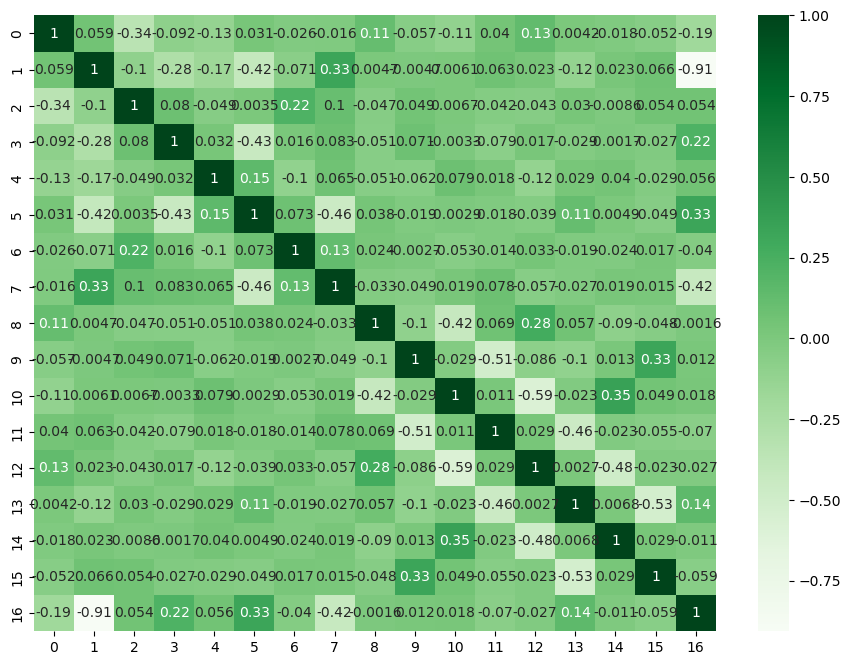

In [90]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

LABEL = 0
df = pd.DataFrame(data[labels==LABEL])
print(cfg.data_config.labels[LABEL])
corr = df.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.show()


# Wavelet transfrorm

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import signal

In [7]:
cfg = get_default_cfg()

cfg.data_config.dataset_class = "FourierDataset"
cfg.data_config.dataset_arguments = FourierDatasetConfig(
    amplitude=False, fourier=False,push_to_max=True,
    rms=False, residuals=False, lc=True, reconstructed_lc=False).__dict__

dataset_name = cfg.data_config.dataset_class + "_".join([f"{k}_{v}" for k,v in cfg.data_config.dataset_arguments.items()])
dataset_name += f"_{MAX_EXAMPLES}"
dataset_path = "/media/bach/DATA/work/classification_of_light_curves/output/datasets/Experiments/"
dataset_path += dataset_name
data = np.load(f"{dataset_path}/train_x.npy")
labels = np.load(f"{dataset_path}/train_y.npy")

In [19]:
IDX = 10
N = 30
widths = np.arange(1, N+1)
cwtmatr = signal.cwt(data[IDX], signal.ricker, widths)

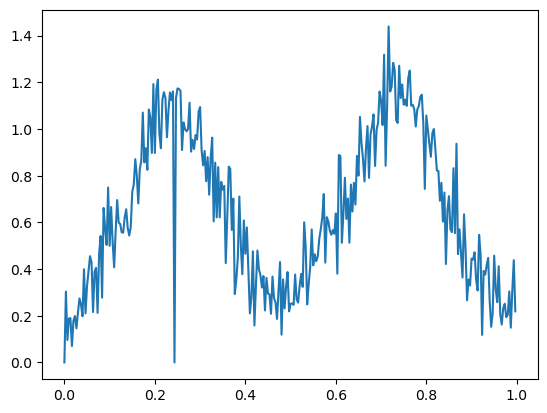

In [20]:
plt.plot(np.linspace(0,1,300, endpoint=False), data[IDX] )

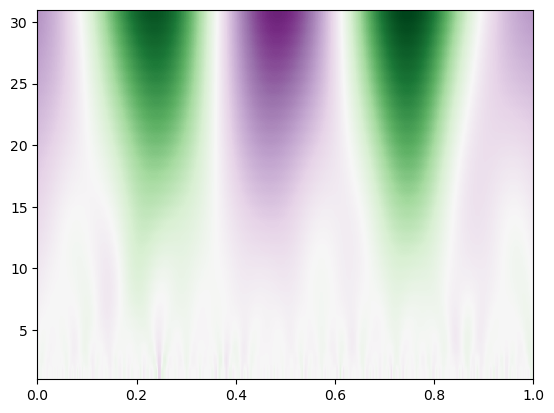

In [26]:
cwtmatr_yflip = np.flipud(cwtmatr)
plt.imshow(cwtmatr_yflip, extent=[0, 1, 1, N+1], cmap='PRGn', aspect='auto',
            vmax=abs(cwtmatr_yflip).max(), vmin=-abs(cwtmatr_yflip).max())
# plt.imshow(cwtmatr_yflip)

(10000, 9000)


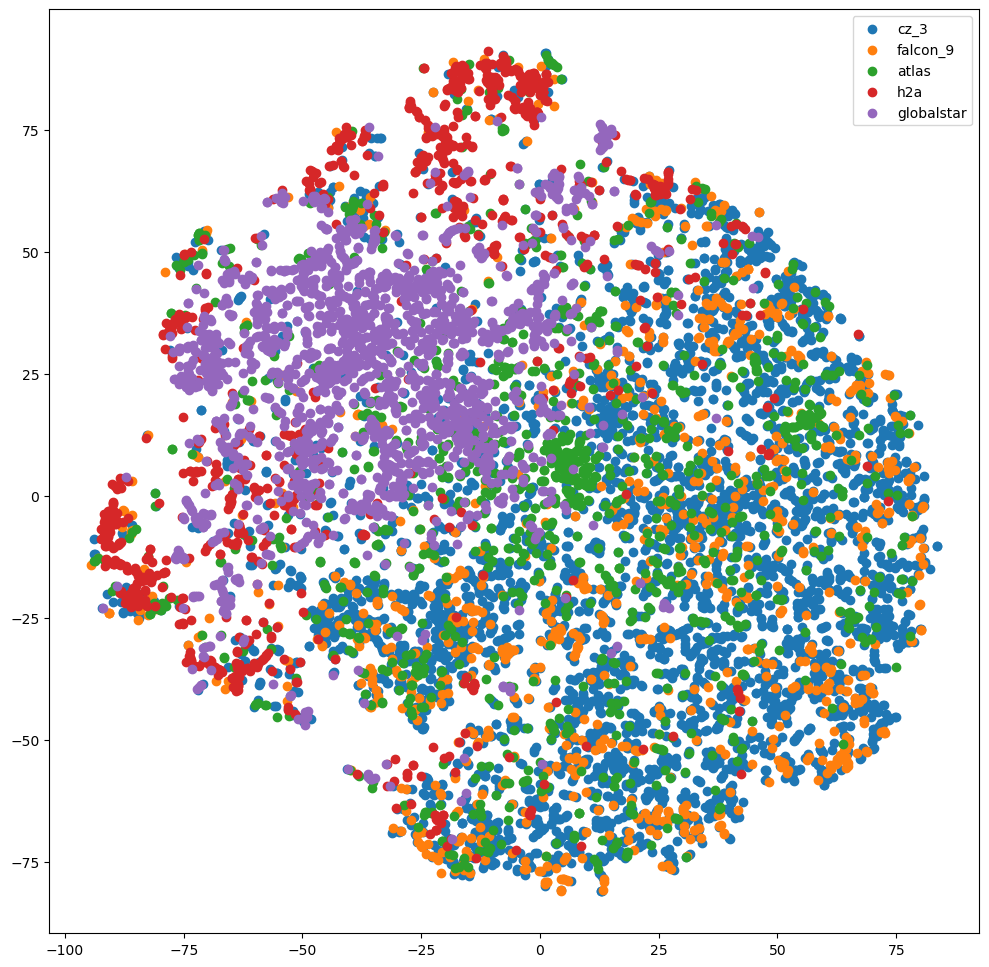

In [34]:

N = 10_000
use_data = data[:N]
use_data = np.array([signal.cwt(d, signal.ricker, widths) for d in use_data]).reshape(N, -1)
print(use_data.shape)
# N = 10_000
reduced_data = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=20).fit_transform(use_data)
reduced_labels = labels[:N]

fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(projection='3d')
ax = fig.add_subplot()

for l in np.unique(reduced_labels):
    ok = reduced_labels == l
    # create 3D scatter plot
    plt.scatter(reduced_data[ok, 0], reduced_data[ok, 1], label=cfg.data_config.labels[l])
    # ax.scatter(reduced_data[ok, 0], reduced_data[ok, 1], reduced_data[ok, 2], label=cfg.data_config.labels[l])
plt.legend()
plt.show()